# Import Dependencies

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from prettytable import PrettyTable

# Load Dataset

In [2]:
df = pd.read_csv('cleaned_tweets.csv')
df.head()

,label,cleaned_tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit not use cause not offer whe...
2,0,bihday majesty
3,0,model love take time ur
4,0,factsguide society motivation


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28229 entries, 0 to 28228
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          28229 non-null  int64 
 1   cleaned_tweet  28228 non-null  object
dtypes: int64(1), object(1)
memory usage: 441.2+ KB


# Remove Null Values

In [4]:
df = df.dropna()

# Lemmatization

In [5]:
wordLemm = WordNetLemmatizer()

def lemmatize(tweet):
    lemmatized_data = []
    for word in tweet.split():
        if len(word) > 1:
            word = wordLemm.lemmatize(word)
            lemmatized_data.append(word)
    return " ".join(lemmatized_data)  

In [6]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize)

# Stemming

In [7]:
wordStem = SnowballStemmer("english", ignore_stopwords=True)

def stem(tweet):
    stemmized_data = []
    for word in tweet.split():
        if len(word) > 1:
            word = wordStem.stem(word)
            stemmized_data.append(word)
    return " ".join(stemmized_data)  

In [8]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(stem)
df.describe(include='all')

,label,cleaned_tweet
count,28228.000000,28228
unique,NaN,28183
top,NaN,make
freq,NaN,3
mean,0.064723,NaN
std,0.246041,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


# Remove Duplicates

In [9]:
df = df.drop_duplicates(subset=['cleaned_tweet'])
df.describe(include='all')

,label,cleaned_tweet
count,28183.000000,28183
unique,NaN,28183
top,NaN,father dysfunct selfish drag kid dysfunct run
freq,NaN,1
mean,0.064684,NaN
std,0.245972,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


# Resample

In [10]:
# Separate classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Undersample majority class
df_majority_downsampled = resample(df_majority, 
                                  replace = False,
                                  n_samples = len(df_minority),
                                  random_state = 42)

# Combine
balanced_df = pd.concat([df_majority_downsampled, df_minority])

In [11]:
balanced_df['label'].value_counts()

label
0    1823
1    1823
Name: count, dtype: int64

In [12]:
balanced_df.shape

(3646, 2)

# Vectorization with CountVectorizer and TDIDF Vectorizer with Unigram

### Train Test Split

In [13]:
train, test = train_test_split(balanced_df, test_size = 0.3, random_state = 42, shuffle = True)

### CountVectorizer

- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
- ngram_range: The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.
- max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus

In [14]:
countvect = CountVectorizer(analyzer = 'word', ngram_range = (1,1), min_df = 10, max_features = 500)

### TFIDF Vectorizer

In [15]:
tfidfvect = TfidfVectorizer(analyzer = 'word', ngram_range = (1,1), min_df = 10, max_features = 500)

### Fit

In [16]:
x_train_count = countvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_count = countvect.transform(test['cleaned_tweet']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_tfidf = tfidfvect.transform(test['cleaned_tweet']).toarray()
y_train = train['label']
y_test = test['label']

## Feature Importance with Logistic Regression and Count Vectorizer with Unigram

In [17]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      act       |   0.6646397452393418  |
|   allahsoil    |   2.6482916022582965  |
|      alli      |    0.53299330466976   |
|     allow      |   0.5579627461680343  |
|      also      |   0.6073843944834443  |
|    altright    |   1.2724115477767461  |
|     alway      |  -0.4292482323468434  |
|      amaz      |  -1.2124033337724662  |
|    america     |   0.704150773136815   |
|    american    |   0.5931665236897187  |
|     anoth      |  -0.39862814367705973 |
|   antisemit    |   1.8361140931490207  |
|     anyth      |  0.03848665397518285  |
|     around     |  -0.5928277810589738  |
|     asian      |   0.9924778955346143  |
|      ask       |  0.45007127770288347  |
|     attack     |  0.022531338419187606 |
|      away      |  -0.49259171241116123 |
|      babi      |  -1.3095072796981053  |
|      back      |   -0.302723560117127  |
|      bad 

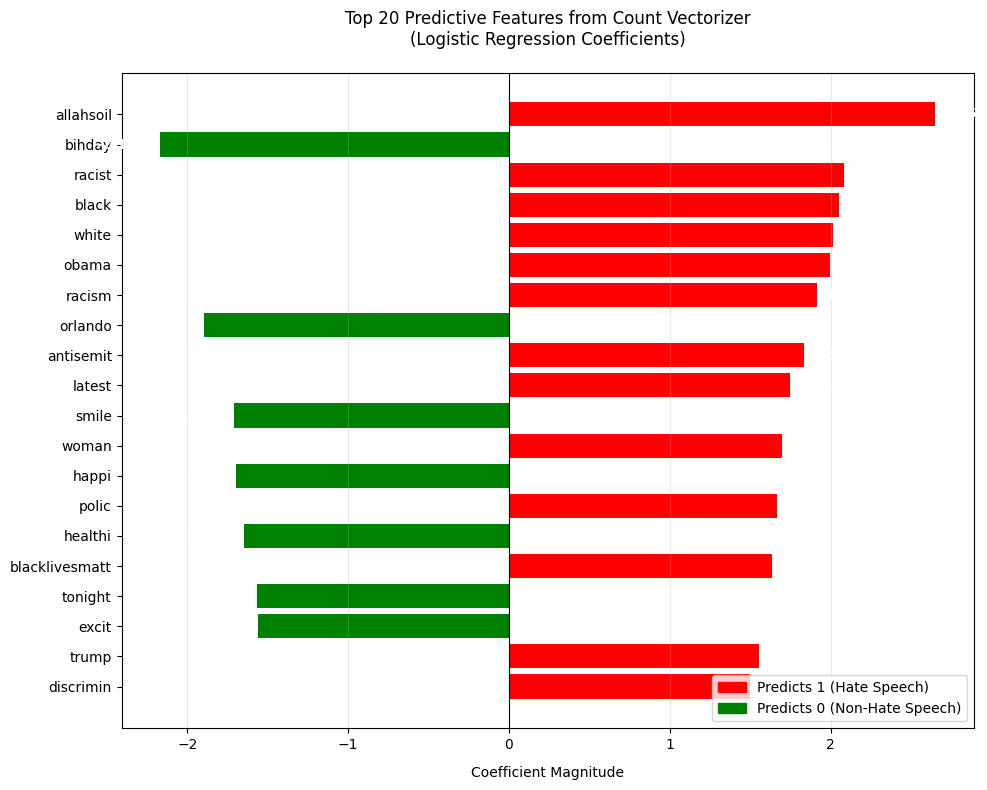

In [18]:
# Extract data from your model (using the same variables as before)
feature_names = countvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from Count Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

## Feature Importance with Logistic Regression and TDIDF Vectorizer with Unigram

In [19]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      act       |   0.6676643536914504  |
|   allahsoil    |   3.1035743997761656  |
|      alli      |   0.7176275020087549  |
|     allow      |   0.7983302272989768  |
|      also      |  0.48043199325598984  |
|    altright    |   1.385123127616789   |
|     alway      |  -0.3165993460571718  |
|      amaz      |  -1.4058938596284734  |
|    america     |   1.1080324796877554  |
|    american    |   1.1034304772951178  |
|     anoth      |  -0.4458445235958981  |
|   antisemit    |   1.7446862422742566  |
|     anyth      |  0.037719913191730715 |
|     around     |   -0.759158955897292  |
|     asian      |   0.9832368643366399  |
|      ask       |   0.4490219939267569  |
|     attack     |   0.3903047907218834  |
|      away      |  -0.5813511708648789  |
|      babi      |  -1.3942298080428075  |
|      back      |  -0.46839892304413516 |
|      bad 

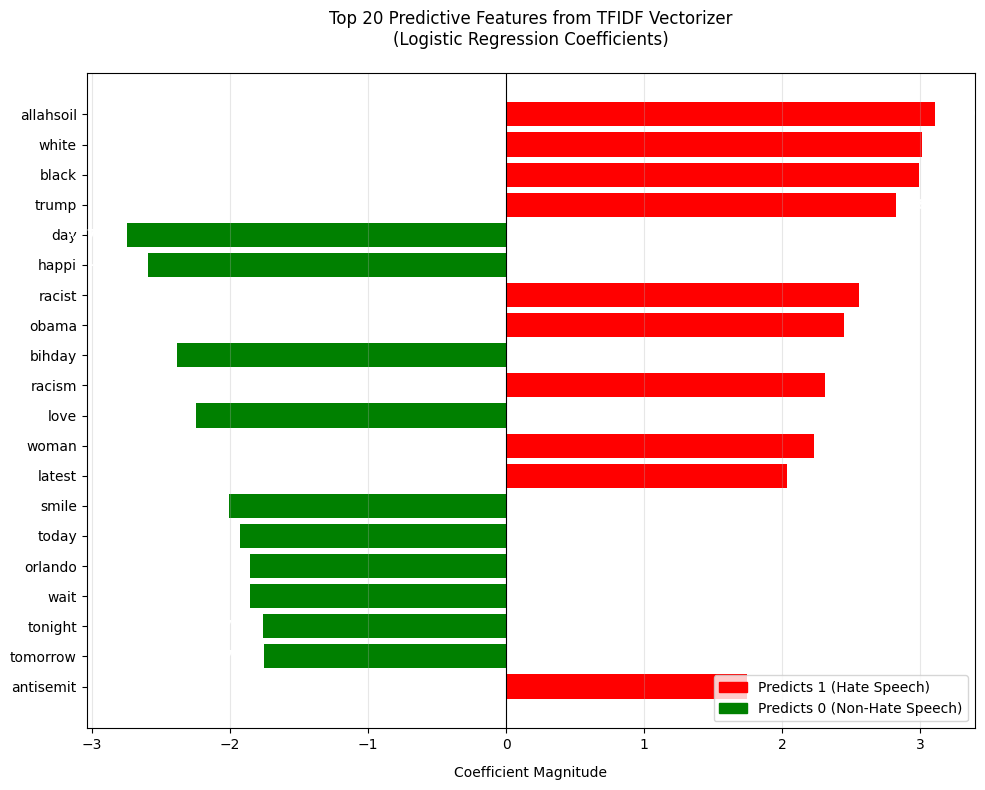

In [20]:
# Extract data from your model (using the same variables as before)
feature_names = tfidfvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from TFIDF Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

# Vectorization with CountVectorizer and TDIDF Vectorizer with Bigram

In [21]:
train, test = train_test_split(balanced_df, test_size = 0.3, random_state = 42, shuffle = True)
countvect = CountVectorizer(analyzer = 'word', ngram_range = (2,2), min_df = 10, max_features = 500)
tfidfvect = TfidfVectorizer(analyzer = 'word', ngram_range = (2,2), min_df = 10, max_features = 500)
x_train_count = countvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_count = countvect.transform(test['cleaned_tweet']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_tfidf = tfidfvect.transform(test['cleaned_tweet']).toarray()
y_train = train['label']
y_test = test['label']

## Feature Importance with Logistic Regression and Count Vectorizer with Bigram

In [22]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+--------------+---------------------+
|   Feature    |        Score        |
+--------------+---------------------+
| blog silver  |  -1.059777460329315 |
| daili thank  |  1.5799302084820455 |
|  father day  | -2.3725418678136077 |
|  feel like   | 0.07913866255424304 |
|  gold forex  | -0.8487036323242307 |
| happi bihday | -1.8696777540204474 |
|  look like   | 0.42037927234969713 |
|   not know   | -0.6904886700752442 |
|  not racist  |  1.5799302084820457 |
|   not wait   | -1.5452859376038546 |
| silver gold  |  -1.059777460329315 |
| white peopl  |  1.7164810074124115 |
|  would not   |  0.5934300282260441 |
+--------------+---------------------+


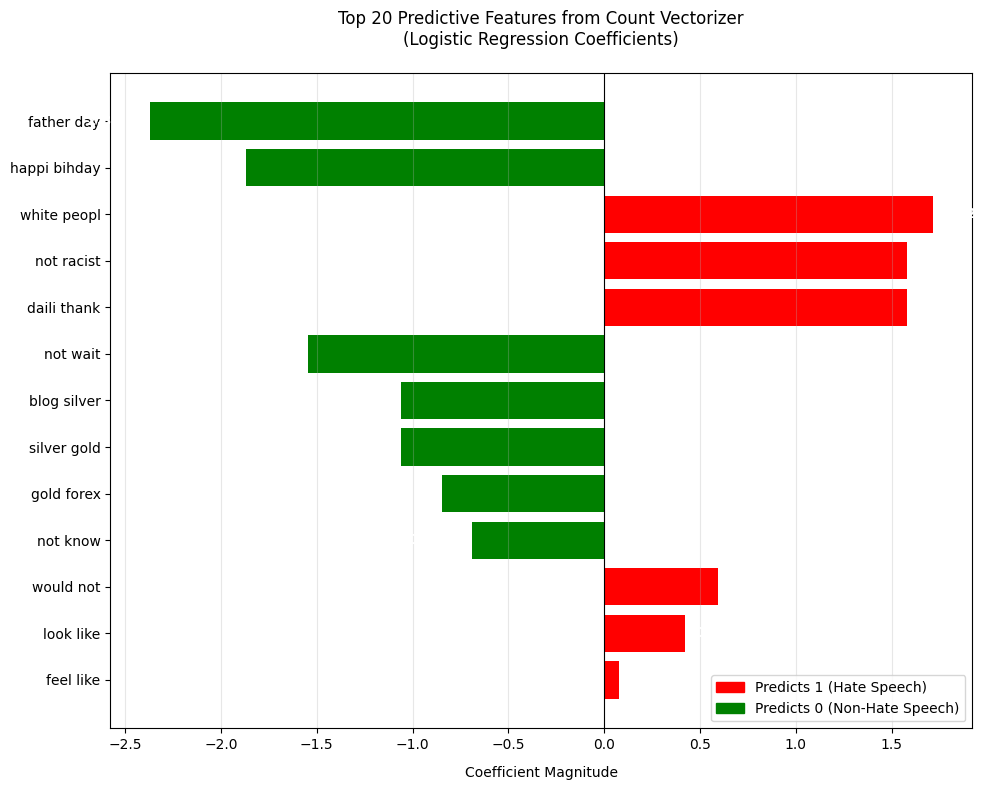

In [23]:
# Extract data from your model (using the same variables as before)
feature_names = countvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from Count Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

## Feature Importance with Logistic Regression and TDIDF Vectorizer with Bigram

In [24]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+--------------+---------------------+
|   Feature    |        Score        |
+--------------+---------------------+
| blog silver  | -1.2687029609595575 |
| daili thank  |  1.5820787046352323 |
|  father day  | -2.4114007956489747 |
|  feel like   | 0.08037745661147852 |
|  gold forex  | -1.0864824464552147 |
| happi bihday |  -1.878118627999151 |
|  look like   | 0.48858075079509256 |
|   not know   | -0.7315210765176472 |
|  not racist  |  1.5820787046352323 |
|   not wait   | -1.5481185092124037 |
| silver gold  | -1.2687029609595575 |
| white peopl  |  1.7236613457843208 |
|  would not   |  0.6131148618083869 |
+--------------+---------------------+


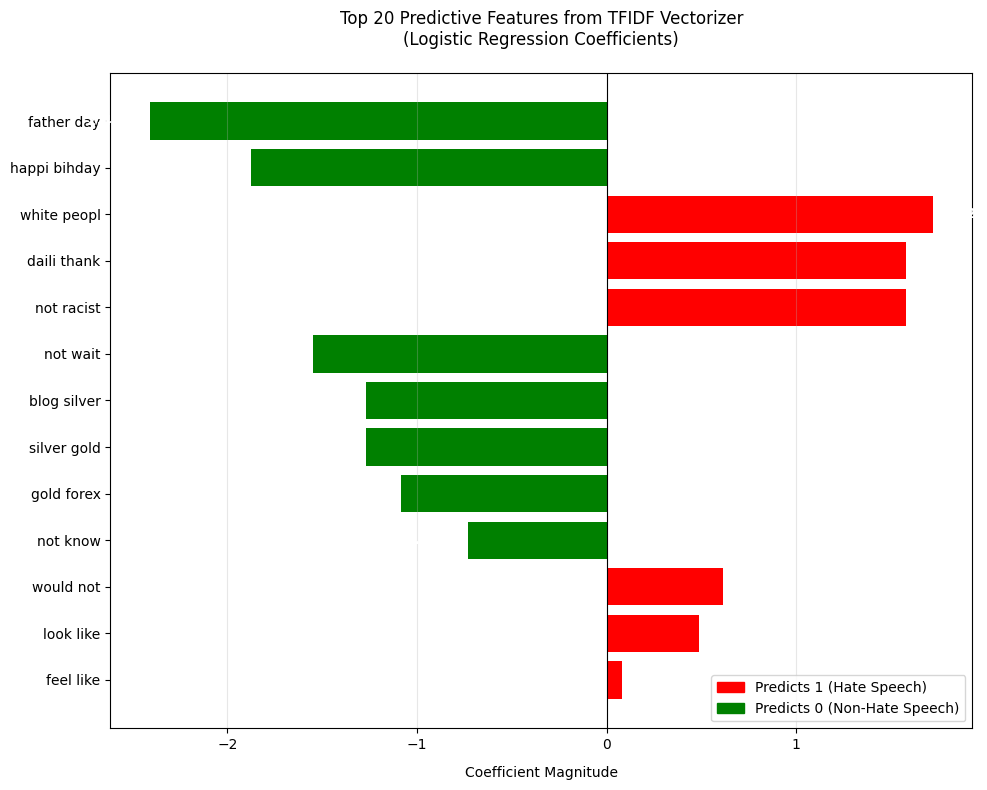

In [25]:
# Extract data from your model (using the same variables as before)
feature_names = tfidfvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from TFIDF Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

# Vectorization with CountVectorizer and TDIDF Vectorizer with Unigram + Bigram

In [26]:
train, test = train_test_split(balanced_df, test_size = 0.3, random_state = 42, shuffle = True)
countvect = CountVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 10, max_features = 500)
tfidfvect = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 10, max_features = 500)
x_train_count = countvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_count = countvect.transform(test['cleaned_tweet']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['cleaned_tweet']).toarray()
x_test_tfidf = tfidfvect.transform(test['cleaned_tweet']).toarray()
y_train = train['label']
y_test = test['label']

## Feature Importance with Logistic Regression and Count Vectorizer with Unigram + Bigram

In [27]:
lgr = LogisticRegression()
lgr.fit(x_train_count, y_train)
lgr.score(x_test_count, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      act       |   0.6566273583096552  |
|   allahsoil    |   2.664213755905429   |
|      alli      |   0.5343707268449125  |
|     allow      |   0.5606752458017179  |
|      also      |   0.5974872744850924  |
|    altright    |   1.276837671694691   |
|     alway      |  -0.4362925864538547  |
|      amaz      |  -1.2062069403656446  |
|    america     |   0.7144248754778155  |
|    american    |   0.5954892257787122  |
|     anoth      |  -0.4215337952713577  |
|   antisemit    |   1.832335181557479   |
|     anyth      |  0.06301541494223281  |
|     around     |  -0.5481865352822366  |
|     asian      |   0.9874906336884725  |
|      ask       |   0.4587828853412286  |
|     attack     |  0.010741325468907574 |
|      away      |  -0.4938543818986507  |
|      babi      |   -1.320293976826292  |
|      back      |  -0.29774772369449654 |
|      bad 

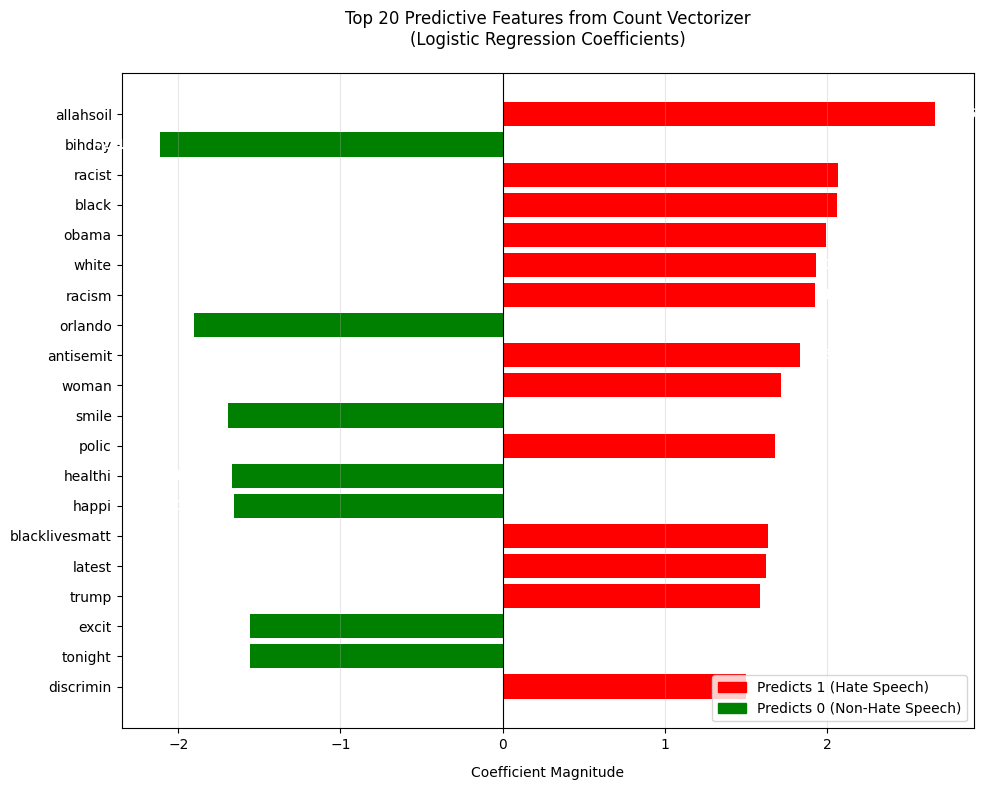

In [28]:
# Extract data from your model (using the same variables as before)
feature_names = countvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from Count Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

## Feature Importance with Logistic Regression and TDIDF Vectorizer with Unigram + Bigram

In [29]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf, y_train)
lgr.score(x_test_tfidf, y_test)
lgr.coef_[0]
i = 0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names_out(), lgr.coef_[0]):
    if i <= 200:
        importantfeature.add_row([feature, importance])
        i = i + 1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      act       |    0.64913698384228   |
|   allahsoil    |   3.0970372467890255  |
|      alli      |   0.7189999929889911  |
|     allow      |   0.7937572884519114  |
|      also      |  0.48221498614374786  |
|    altright    |   1.3830880587535104  |
|     alway      |  -0.31306982766409425 |
|      amaz      |   -1.397509283454941  |
|    america     |   1.1131940149528796  |
|    american    |   1.1018875717219325  |
|     anoth      |  -0.4633728443799706  |
|   antisemit    |   1.7403982487009286  |
|     anyth      |  0.032372980874673246 |
|     around     |  -0.7168396086188269  |
|     asian      |   0.9872327058448985  |
|      ask       |  0.44639486717845167  |
|     attack     |  0.37905570763285873  |
|      away      |   -0.575276447947022  |
|      babi      |   -1.393129590409168  |
|      back      |  -0.4648155287423693  |
|      bad 

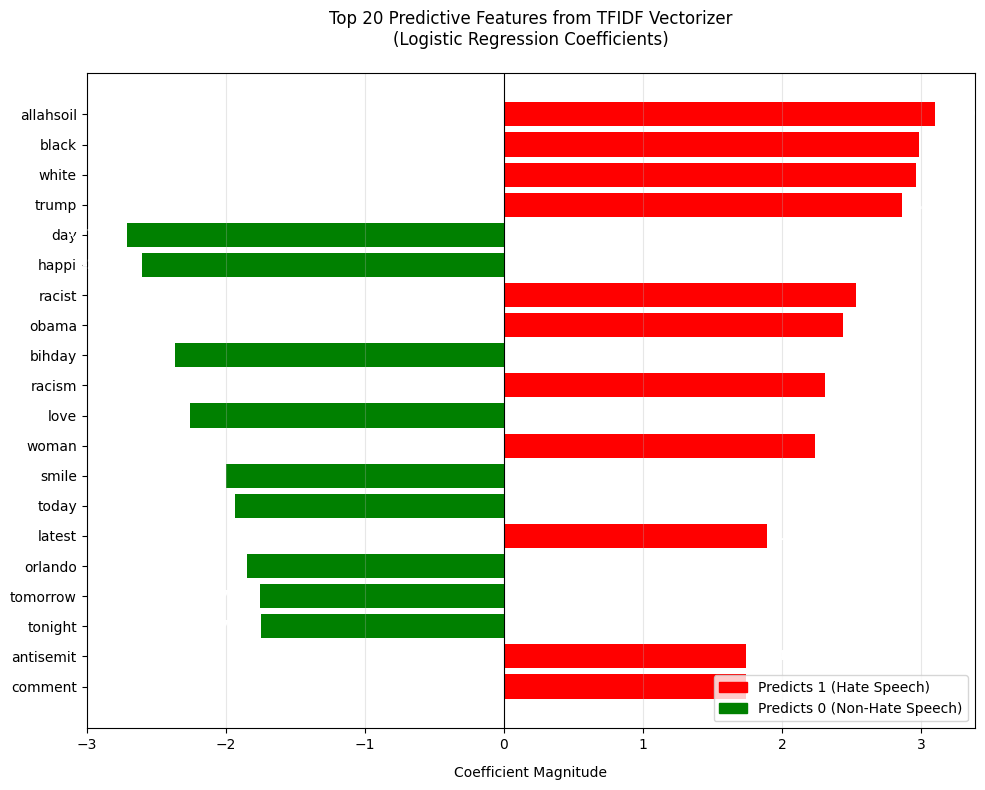

In [30]:
# Extract data from your model (using the same variables as before)
feature_names = tfidfvect.get_feature_names_out()
coefficients = lgr.coef_[0]

# Create a DataFrame and sort by absolute coefficient value
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)  # Top 20 features

# Create the visualization
plt.figure(figsize=(10, 8))
colors = ['green' if x < 0 else 'red' for x in feature_imp['Coefficient']]
bars = plt.barh(feature_imp['Feature'], feature_imp['Coefficient'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    label = f"{width:.2f}"
    if width < 0:
        plt.text(width - 0.15, bar.get_y() + bar.get_height()/2, label, 
                ha='right', va='center', color='white', fontweight='bold')
    else:
        plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, label,
                ha='left', va='center', color='white', fontweight='bold')

# Formatting
plt.title('Top 20 Predictive Features from TFIDF Vectorizer\n(Logistic Regression Coefficients)', pad=20)
plt.xlabel('Coefficient Magnitude', labelpad=10)
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)

# Legend
red_patch = mpatches.Patch(color='red', label='Predicts 1 (Hate Speech)')
green_patch = mpatches.Patch(color='green', label='Predicts 0 (Non-Hate Speech)')
plt.legend(handles=[red_patch, green_patch], loc='lower right')

plt.tight_layout()
plt.show()

After combining unigram + bigram, the top predictive features were unigrams, but the unigrams had higher coefficient magnitude than just using unigrams only.